Text(0.5,0.98,'SP500 Price')

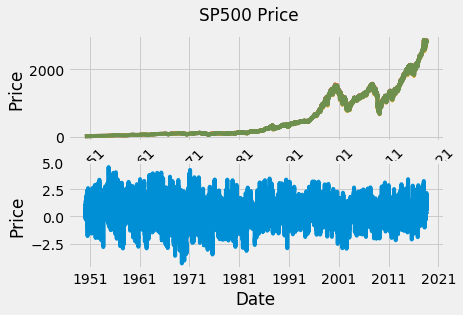

In [17]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt


#SP500_BASE_DIRECTORY = "C:\Users\Shane\"
SP500_BASE_DIRECTORY = os.getcwd()
SP500_DATA_DIRECTORY = SP500_BASE_DIRECTORY + "\\data\\"
SP500_DATA_FILENAME = "SP500.csv"
OUTPUT_DIRECTORY = SP500_BASE_DIRECTORY + "\\output\\"
OUTPUT_EXCEL_FILENAME = "Bear Market Analysis.xlsx"

sp500_df = pd.read_csv(SP500_DATA_DIRECTORY + SP500_DATA_FILENAME)
sp500_df['Date'] = pd.to_datetime(sp500_df.Date)
#sp500_df = sp500_df.sort_values(by=['Date'], ascending=False)

fig = plt.figure()
ax1 = plt.subplot(2, 1, 1)
ax1.plot(sp500_df['Date'], sp500_df['SP500_Open'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_High'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_Low'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_Close'])
plt.ylabel('Price')
ax1.grid(True)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(sp500_df['Date'], sp500_df['SP500_SQN25'])
plt.ylabel('SQN 25')
ax2.grid(True)

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)

plt.xlabel('Date')
plt.ylabel('Price')
plt.suptitle('SP500 Price')


In [15]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='shane.brewer', api_key='Utd2w2H5xUb4MfnMmlNZ')
plotly.tools.set_config_file(world_readable=True, sharing='public')

sp500_price_trace = go.Candlestick(
    x=sp500_df['Date'],
    close=sp500_df['SP500_Close'],
    high=sp500_df['SP500_High'],
    low=sp500_df['SP500_Low'],
    open=sp500_df['SP500_Open'],
    xaxis="x",
    yaxis="y"
)

sqn25_trace = go.Scatter(
    x=sp500_df['Date'],
    y=sp500_df['SP500_SQN25'],
    xaxis="x",
    yaxis="y2"
)

data = [sp500_price_trace, sqn25_trace]

layout = {
    "hovermode": "closest", 
    "showlegend": False, 
    "title": "S&P500 Price Chart", 
    "xaxis": {
        "anchor": "y2",
        "domain": [0, 1],
        "title": "Date",
        "autorange": True,
        "rangeselector": {
            "x": 0.5, 
            "y": -0.055, 
            "buttons": [
            {
                "count": 1, 
                "label": "RESET", 
                "step": "all"
            }, 
            {
                "count": 1, 
                "label": "1 YR", 
                "step": "year", 
                "stepmode": "backward"
            }, 
            {
                "count": 3, 
                "label": "3 MO", 
                "step": "month", 
                "stepmode": "backward"
            }, 
            {
                "count": 1, 
                "label": "1 MO", 
                "step": "month", 
                "stepmode": "backward"
            }
            ], 
            "font": {"size": 9}, 
            "visible": True, 
            "xanchor": "center"
        }, 
    }, 
    "yaxis": {
        "anchor": "x",
        "domain": [0.27, 0.95],
        "title": "Price",
        "autorange": True
    },
    "yaxis2": {
        "anchor": "x",
        "domain": [0.05, 0.23],
        "title": "SQN25",
        "autorange": True
    }
}

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='SP500_Price_Chart') 

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~shane.brewer/10.embed" height="525px" width="100%"></iframe>

In [ ]:
sqn25_trace = go.Scatter(
    x=sp500_df['Date'],
    y=sp500_df['SP500_SQN25']
)
data = [sp500_price_trace, sqn25_trace]
layout = {
    "hovermode": "closest", 
    "showlegend": False, 
    "title": "S&P500 Price Chart", 
    "xaxis": {
        "domain": [0, 1], 
        "title": "Date"
    }, 
    "yaxis": {
        "domain": [0, 1],
        "title": "Price"
    }
}

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='SP500_Price_Chart') 

In [7]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

sp500_drawdown_df = sp500_df[['Date', 'SP500_Close']]
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff=sp500_drawdown_df['SP500_Close'] -
                                                              sp500_drawdown_df['SP500_Close'].shift(1))
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff_Percentage=sp500_drawdown_df['SP500_Close'].pct_change() * 100)

sp500_drawdown_df = sp500_drawdown_df.assign(Cumulative_Price_Diff=sp500_drawdown_df['Close_Price_Diff'].cumsum())

sp500_drawdown_df = sp500_drawdown_df.assign(Max_Gain=sp500_drawdown_df['Cumulative_Price_Diff'].expanding(2).max())

sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough=sp500_drawdown_df['Cumulative_Price_Diff'] -
                                                      sp500_drawdown_df['Max_Gain'])
sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough_Percentage=sp500_drawdown_df['Peak_To_Trough'] /
                                                                 (sp500_drawdown_df['SP500_Close'] -
                                                                 sp500_drawdown_df['Peak_To_Trough']) * 100)
wb = Workbook()
ws = wb.create_sheet("Drawdowns")
ws.title = "Drawdowns"
for row in dataframe_to_rows(sp500_drawdown_df, index=True, header=True):
    ws.append(row)
wb.save(OUTPUT_DIRECTORY + OUTPUT_EXCEL_FILENAME)

drawdown_percentage_threshold = 20
max_drawdown_percentage = 0
drawdown_df = pd.DataFrame()

for row in sp500_drawdown_df.itertuples():
    if math.isnan(getattr(row, 'Peak_To_Trough')):
        continue
    if math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5) and max_drawdown_percentage < \
            (drawdown_percentage_threshold * -1):
        # Now making new highs, and the last drawdown reached the minimum threshold
        start_date = sp500_drawdown_df.at[last_peak_index, 'Date']
        end_date = sp500_drawdown_df.at[max_drawdown_index, 'Date']
        num_days = (sp500_drawdown_df.at[max_drawdown_index, 'Date'] -
                    sp500_drawdown_df.at[last_peak_index, 'Date']).days

        df = pd.DataFrame({'Start_Date': start_date,
                           'Start_Date_Index': last_peak_index,
                           'End_Date': end_date,
                           'End_Date_Index': max_drawdown_index,
                           'Total_Drawdown_Percentage': max_drawdown_percentage,
                           'Num_Days': num_days}, index=[0])
        
        drawdown_df = drawdown_df.append(df, ignore_index=True)
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5):
        # Now making new highs but didn't reach minimum drawdown percentage threshold. Reset variables.
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif max_drawdown_percentage > getattr(row, 'Peak_To_Trough_Percentage'):
        max_drawdown_percentage = getattr(row, 'Peak_To_Trough_Percentage')
        max_drawdown_index = row.Index
pd.DataFrame(drawdown_df)

,Start_Date,Start_Date_Index,End_Date,End_Date_Index,Total_Drawdown_Percentage,Num_Days
0,1956-08-03,1652,1957-10-22,1958,-21.474617,445
1,1961-12-12,3000,1962-06-26,3135,-27.973568,196
2,1966-02-09,4048,1966-10-07,4215,-22.177334,240
3,1968-11-29,4731,1970-05-26,5100,-36.061641,543
4,1973-01-11,5765,1974-10-03,6201,-48.203593,630
5,1980-11-28,7756,1982-08-12,8186,-27.113578,622
6,1987-08-25,9459,1987-12-04,9530,-33.509517,101
7,2000-03-24,12640,2002-10-09,13273,-49.146950,929
8,2007-10-09,14531,2009-03-09,14886,-56.775389,517


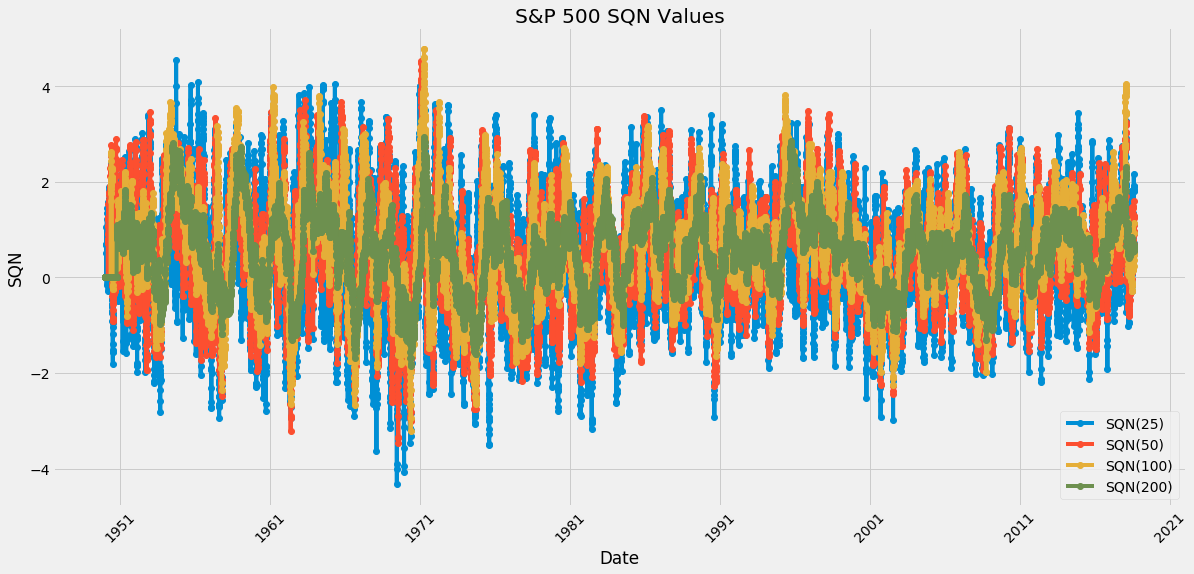

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
fig = plt.figure()
fig.set_size_inches(18.5, 9.5)
ax1 = plt.subplot2grid((1, 1), (0, 0))
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN25'], linestyle='-', label='SQN(25)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN50'], linestyle='-', label='SQN(50)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN100'], linestyle='-', label='SQN(100)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN200'], linestyle='-', label='SQN(200)')
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
ax1.grid(True)

plt.title('S&P 500 SQN Values')
plt.xlabel('Date')
plt.ylabel('SQN')
plt.legend()
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.savefig(OUTPUT_DIRECTORY + 'SP500_SQN.png', dpi=100)
plt.show()

In [10]:
import statistics

sqn_df = pd.DataFrame()

sqn25_avg = statistics.mean(sp500_df['SP500_SQN25'])
sqn25_stdev = statistics.stdev(sp500_df['SP500_SQN25'])
sqn25_min = min(sp500_df['SP500_SQN25'])
sqn25_max = max(sp500_df['SP500_SQN25'])

sqn50_avg = statistics.mean(sp500_df['SP500_SQN50'])
sqn50_stdev = statistics.stdev(sp500_df['SP500_SQN50'])
sqn50_min = min(sp500_df['SP500_SQN50'])
sqn50_max = max(sp500_df['SP500_SQN50'])

sqn100_avg = statistics.mean(sp500_df['SP500_SQN100'])
sqn100_stdev = statistics.stdev(sp500_df['SP500_SQN100'])
sqn100_min = min(sp500_df['SP500_SQN100'])
sqn100_max = max(sp500_df['SP500_SQN100'])
    
sqn200_avg = statistics.mean(sp500_df['SP500_SQN200'])
sqn200_stdev = statistics.stdev(sp500_df['SP500_SQN200'])
sqn200_min = min(sp500_df['SP500_SQN200'])
sqn200_max = max(sp500_df['SP500_SQN200'])

sqn_df = pd.DataFrame({
    'START_DATE': sp500_df.loc[0, 'Date'],
    'END_DATE': sp500_df.loc[len(sp500_df)-1, 'Date'],
    'SQN25_AVG': sqn25_avg, 
    'SQN25_STDEV': sqn25_stdev,
    'SQN25_MIN': sqn25_min,
    'SQN25_MAX': sqn25_max,
    'SQN50_AVG': sqn50_avg,
    'SQN50_STDEV': sqn50_stdev,
    'SQN50_MIN': sqn50_min,
    'SQN50_MAX': sqn50_max,
    'SQN100_AVG': sqn100_avg,
    'SQN100_STDEV': sqn100_stdev,
    'SQN100_MIN': sqn100_min,
    'SQN100_MAX': sqn100_max,
    'SQN200_AVG': sqn200_avg,
    'SQN200_STDEV': sqn200_stdev,
    'SQN200_MIN': sqn200_min,
    'SQN200_MAX': sqn200_max}, index=[0])


for row in drawdown_df.itertuples():
    # Slice the SP500 df based on start and end dates of the drawdown
    start_index = getattr(row, 'Start_Date_Index')
    end_index = getattr(row, 'End_Date_Index')
    drawdown_slice_df = sp500_df[start_index:end_index + 1]
    
    sqn25_avg = statistics.mean(drawdown_slice_df['SP500_SQN25'])
    sqn25_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN25'])
    sqn25_min = min(drawdown_slice_df['SP500_SQN25'])
    sqn25_max = max(drawdown_slice_df['SP500_SQN25'])
    
    sqn50_avg = statistics.mean(drawdown_slice_df['SP500_SQN50'])
    sqn50_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN50'])
    sqn50_min = min(drawdown_slice_df['SP500_SQN50'])
    sqn50_max = max(drawdown_slice_df['SP500_SQN50'])
    
    sqn100_avg = statistics.mean(drawdown_slice_df['SP500_SQN100'])
    sqn100_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN100'])
    sqn100_min = min(drawdown_slice_df['SP500_SQN100'])
    sqn100_max = max(drawdown_slice_df['SP500_SQN100'])
        
    sqn200_avg = statistics.mean(drawdown_slice_df['SP500_SQN200'])
    sqn200_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN200'])
    sqn200_min = min(drawdown_slice_df['SP500_SQN200'])
    sqn200_max = max(drawdown_slice_df['SP500_SQN200'])
    
    df = pd.DataFrame({
        'START_DATE': getattr(row, 'Start_Date'),
        'END_DATE': getattr(row, 'End_Date'),
        'SQN25_AVG': sqn25_avg, 
        'SQN25_STDEV': sqn25_stdev,
        'SQN25_MIN': sqn25_min,
        'SQN25_MAX': sqn25_max,
        'SQN50_AVG': sqn50_avg,
        'SQN50_STDEV': sqn50_stdev,
        'SQN50_MIN': sqn50_min,
        'SQN50_MAX': sqn50_max,
        'SQN100_AVG': sqn100_avg,
        'SQN100_STDEV': sqn100_stdev,
        'SQN100_MIN': sqn100_min,
        'SQN100_MAX': sqn100_max,
        'SQN200_AVG': sqn200_avg,
        'SQN200_STDEV': sqn200_stdev,
        'SQN200_MIN': sqn200_min,
        'SQN200_MAX': sqn200_max}, index=[0])

    sqn_df = sqn_df.append(df, ignore_index=True)

# Create a table of background colors based on the SQN values


price_table = go.Table(
    header=dict(values=list(sqn_df.columns),
                fill=dict(color='#C2D4FF'),
                align=['left'] * 5,
                font=dict(color='black', size=12)),
    cells=dict(values=[sqn_df.START_DATE,
                       sqn_df.END_DATE,
                       sqn_df.SQN25_AVG,
                       sqn_df.SQN25_STDEV,
                       sqn_df.SQN25_MIN,
                       sqn_df.SQN25_MAX,
                       sqn_df.SQN50_AVG,
                       sqn_df.SQN50_STDEV,
                       sqn_df.SQN50_MIN,
                       sqn_df.SQN50_MAX,
                       sqn_df.SQN100_AVG,
                       sqn_df.SQN100_STDEV,
                       sqn_df.SQN100_MIN,
                       sqn_df.SQN100_MAX,
                       sqn_df.SQN200_AVG,
                       sqn_df.SQN200_STDEV,
                       sqn_df.SQN200_MIN,
                       sqn_df.SQN200_MAX],
               fill=dict(color='#F5F8FF'),
               align=['left'] * 5))

table_data = [price_table]
py.iplot(table_data, filename='Bear_Market_Research_Table')

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~shane.brewer/4.embed" height="525px" width="100%"></iframe>